In [1]:
import bz2, json, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import tempfile, subprocess
from statistics import linear_regression

sns.set_theme(font_scale=0.81666666666666666)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'''
\RequirePackage[T1]{fontenc}
\RequirePackage[tt=false, type1=true]{libertine}
\RequirePackage[varqu]{zi4}
\RequirePackage[libertine]{newtxmath}
''')
plt.rcParams['xtick.major.pad']=-4
plt.rcParams['ytick.major.pad']=-4
plt.rcParams["font.size"] = 8
import plotly as ply
import plotly.express as px
pd.options.display.max_columns = None
import plotly.io as pio
pio.renderers.default = 'notebook'
from matplotlib.collections import LineCollection

In [2]:
def mean_numeric(x):
    if isinstance(x.iloc[0], str):
        return x.iloc[0]
    elif isinstance(x.iloc[0], bool):
        return x.iloc[0]
    elif isinstance(x.iloc[0], dict):
        return x.iloc[0]
    else:
        return x.mean()

def average_out_total_times(frame_like):
    return frame_like.groupby(["instance_name", "run_type"]).agg(mean_numeric)

# Load Data

In [3]:
instance_data = json.load(open("../../../instance_sets/instance_info.json"))
instance_dataframe = pd.DataFrame(instance_data).T
instance_dataframe.reset_index(inplace=True, drop=True)
instance_dataframe

,instance_name,instance_filename,instance_dir,instance_fulldir,num_points
0,o20190827_143636_13_hard_instances_1_p3,o20190827_143636_13_hard_instances_1_p3.instan...,evolved_instances,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,306
1,20190827_143536_62_hard_instances_1_p1,20190827_143536_62_hard_instances_1_p1.instanc...,evolved_instances,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,306
2,o20190827_143636_36_hard_instances_0_p2_p6_p5,o20190827_143636_36_hard_instances_0_p2_p6_p5....,evolved_instances,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,306
3,20190827_143536_59_hard_instances_2,20190827_143536_59_hard_instances_2.instance.bz2,evolved_instances,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,306
4,o20190827_143636_33_hard_instances_6,o20190827_143636_33_hard_instances_6.instance.bz2,evolved_instances,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,306
...,...,...,...,...,...
9886,uniform-39000000-0,uniform-39000000-0.txt.bz2,random,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,39000000
9887,spanning_ratio_instance,spanning_ratio_instance.txt.bz2,public_instance_set,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,7
9888,c91926,c91926.json.bz2,numerically_difficult,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,91926
9889,c63,c63.json.bz2,numerically_difficult,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,63


In [4]:
with bz2.open("brief_run_data.json.bz2", "rt") as f:
    brief_data = json.load(f)
for element in brief_data:
    if "run_stats" in element:
        for x in element["run_stats"]:
            element[x] = element["run_stats"][x]
        for x in element["max_resource_usage"]:
            element["max_res_" + x] = element["max_resource_usage"][x]
        del element["run_stats"]
for element in brief_data:
    if "max_res_swap_usage" in element:
        element["max_res_total_memory"] = element["max_res_swap_usage"] + element["max_res_max_resident_set_size"]
    if "num_nonsimple_faces" in element: continue
    if not element["run_succeeded"]: continue
    if element["face_triangulation_stats"] is None:
        element["num_nonsimple_faces"] = 0
    else:
        element["num_nonsimple_faces"] = len(element["face_triangulation_stats"])
for element in brief_data:
    if "num_points" not in element:
        if element["run_succeeded"]:
            print("No num_points for", element["instance_name"])
        instance_name = element["instance_name"]
        element["num_points"] = instance_data[instance_name]["num_points"]

In [5]:
dataframe = pd.DataFrame(brief_data)
dataframe["total_time"] = dataframe["diamond_time"] + dataframe["lmt_time"] + dataframe["advanced_lmt_time"] + dataframe["face_triangulation_time"]
dataframe["max_relative_gap"] = dataframe["max_gap"] / dataframe["total_weight_lb"]
min_total_time = dataframe[["instance_name", "run_type", "total_time"]].groupby(["instance_name", "run_type"])["total_time"].transform("min")
dataframe["min_total_time"] = min_total_time
max_total_time = dataframe[["instance_name", "run_type", "total_time"]].groupby(["instance_name", "run_type"])["total_time"].transform("max")
dataframe["max_total_time"] = max_total_time
dataframe["total_time_dev"] = (dataframe["max_total_time"] - dataframe["min_total_time"]) / dataframe["min_total_time"]
dataframe["is_uniform_random"] = (dataframe["instance_dir"] == "./02_raw_output/random") & (dataframe["instance_name"].str.startswith("uniform-"))
lmap = {'./02_raw_output/odd_wheels': 'odd wheels',
        './02_raw_output/random': 'random',
        './02_raw_output/numerically_difficult': 'numerical',
        './02_raw_output/public_instance_set': 'public',
        './02_raw_output/evolved_instances': 'evolved'}
dataframe["instance_class"] = dataframe['instance_dir'].map(lmap)

In [6]:
random = dataframe[dataframe["instance_dir"] == "./02_raw_output/random"]
numerical = dataframe[dataframe["instance_dir"] == "./02_raw_output/numerically_difficult"]
odd_wheels = dataframe[dataframe["instance_dir"] == "./02_raw_output/odd_wheels"]
evolved = dataframe[dataframe["instance_dir"] == "./02_raw_output/evolved_instances"]
public_set = dataframe[dataframe["instance_dir"] == "./02_raw_output/public_instance_set"]

# Runtime Plot

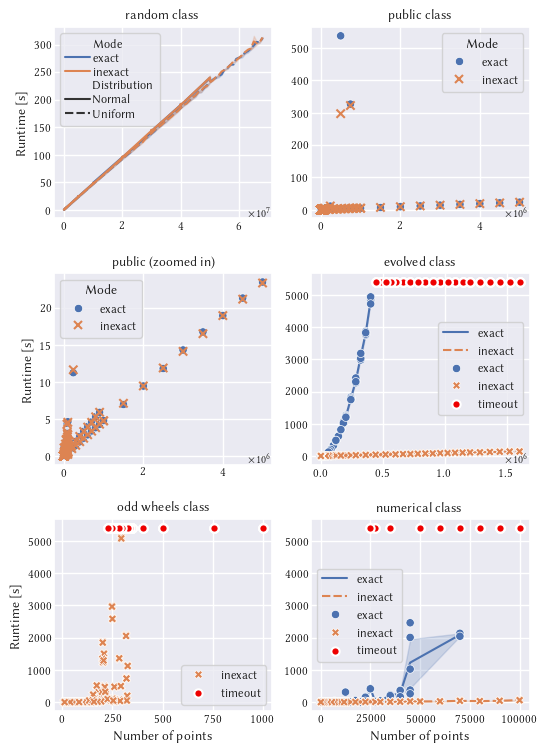

In [21]:
fig, ((axrnd, axpub1), (axpub2, axev), (axodd, axnum)) = plt.subplots(3, 2)
fig.tight_layout(h_pad=1.5, w_pad=1.5)
fig.set_size_inches(5.2, 7.5)
hue_order=['exact', 'inexact']

## random instance class
sns.lineplot(random.query("num_points <= 68000000"),
             x="num_points", y="total_time", hue="run_type", style="is_uniform_random", zorder=10, ax=axrnd, hue_order=hue_order)
#sns.scatterplot(random, x="num_points", y="total_time", hue="run_type", style="is_uniform_random", zorder=11, ax=axrnd)
axrnd.legend(handletextpad=0.2, labelspacing=0.2, loc="upper left")
text_remap = {"run_type": "Mode", "is_uniform_random": "Distribution", "False": "Normal", "True": "Uniform"}
for label in axrnd.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
axrnd.set_ylabel("Runtime [s]")
axrnd.set_xlabel(None)
axrnd.set_title("random class")
axrnd.get_xaxis().get_offset_text().set_visible(False)
axrnd.annotate(r'$\times 10^7$', xy=(0.89, 0.005), xycoords='axes fraction')

## public instance class
sns.scatterplot(average_out_total_times(
    public_set[public_set["run_type"] == "exact"]), 
    hue="run_type", style="run_type", x="num_points", y="total_time", 
    ax=axpub1, palette=["C0"], zorder=10, markers=["o"])
sns.scatterplot(average_out_total_times(
    public_set[public_set["run_type"] == "inexact"]), 
    hue="run_type", style="run_type", x="num_points", y="total_time", 
    ax=axpub1, palette=["C1"], zorder=15, markers=["x"], linewidth=1.5)
axpub1.get_legend().set_title("Mode")
axpub1.set_title("public class")
axpub1.set_ylabel(None)
axpub1.set_xlabel(None)
axpub1.get_xaxis().get_offset_text().set_visible(False)
axpub1.annotate(r'$\times 10^6$', xy=(0.89, 0.005), xycoords='axes fraction')

pub_no_outliers = public_set[(public_set["instance_name"] != "lra498378") & (public_set["instance_name"] != "lrb744710")]
sns.scatterplot(average_out_total_times(pub_no_outliers[pub_no_outliers["run_type"] == "exact"]), 
    hue="run_type", style="run_type", x="num_points", y="total_time", 
    ax=axpub2, palette=["C0"], zorder=10, markers=["o"])
sns.scatterplot(average_out_total_times(pub_no_outliers[pub_no_outliers["run_type"] == "inexact"]), 
    hue="run_type", style="run_type", x="num_points", y="total_time", 
    ax=axpub2, palette=["C1"], zorder=15, markers=["x"], linewidth=1.5)
axpub2.get_legend().set_title("Mode")
axpub2.set_title("public (zoomed in)")
axpub2.set_ylabel("Runtime [s]")
axpub2.set_xlabel(None)
axpub2.get_xaxis().get_offset_text().set_visible(False)
axpub2.annotate(r'$\times 10^6$', xy=(0.89, 0.005), xycoords='axes fraction')

# evolved dataset
sns.lineplot(evolved.sort_values("run_type"), x="num_points", y="total_time", hue="run_type", style="run_type", zorder=10, ax=axev)
sns.scatterplot(evolved.sort_values("run_type"), x="num_points", y="total_time", hue="run_type", style="run_type", zorder=11, ax=axev)
axev.get_legend().set_title("Mode")
axev.set_title("evolved class")
evolved_failed = evolved.query("run_succeeded == False")
assert evolved_failed.query("run_type == 'inexact'").empty
failpoints = evolved_failed[["instance_name", "run_type", "num_points"]]
sns.scatterplot(failpoints, x="num_points", color="#ee0000", y=5400.0, ax=axev, zorder=12, markers=["o"], linewidth=1.5, label="timeout")
axev.set_xlabel(None)
axev.set_ylabel(None)
axev.get_xaxis().get_offset_text().set_visible(False)
axev.annotate(r'$\times 10^6$', xy=(0.89, 0.005), xycoords='axes fraction')

# odd wheels
sns.scatterplot(odd_wheels.query("run_succeeded == True and run_type == 'inexact'"), x="num_points", y="total_time", color="C1", ax=axodd, 
                style="run_type", zorder=10, style_order=["_hidden", "inexact"])
odd_failed = odd_wheels.query("run_succeeded == False and run_type == 'inexact'")
failpoints = odd_failed[["instance_name", "run_type", "num_points"]]
sns.scatterplot(failpoints.query("num_points <= 1000"), x="num_points", color="#ee0000", 
                y=5400.0, ax=axodd, zorder=12, markers=["x"], linewidth=1.5, label="timeout")
axodd.set_ylabel("Runtime [s]")
axodd.set_xlabel("Number of points")
axodd.set_title("odd wheels class")

# numerical
sns.lineplot(numerical.sort_values("run_type"), x="num_points", y="total_time", hue="run_type", style="run_type", zorder=10, ax=axnum)
sns.scatterplot(numerical.sort_values("run_type"), x="num_points", y="total_time", hue="run_type", style="run_type", zorder=11, ax=axnum)
axnum.set_ylabel(None)
axnum.get_legend().set_title("Mode")
axnum.set_title("numerical class")
axnum.set_xlabel("Number of points")
numerical_failed = numerical.query("run_succeeded == False")
assert numerical_failed.query("run_type == 'inexact'").empty
failpoints = numerical_failed[["instance_name", "run_type", "num_points"]]
sns.scatterplot(failpoints, x="num_points", color="#ee0000", y=5400.0, ax=axnum, zorder=12, markers=["o"], linewidth=1.5, label="timeout")

#evolved_failed = evolved.query("run_succeeded == False")
#assert evolved_failed.query("run_type == 'inexact'").empty
#failpoints = evolved_failed[["instance_name", "run_type", "num_points"]]
#numerical_failed = numerical.query("run_succeeded == False")
#numerical_failed.sort_values(["instance_name", "run_type"])
plt.savefig("runtime_overview_by_instance_class.pdf", bbox_inches="tight")

# Runtime of uniform instances with swap

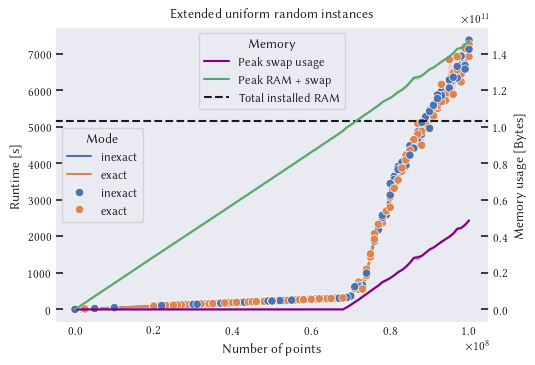

In [8]:
uniform = random[random["is_uniform_random"]]
ax = plt.gca()
twinax = ax.twinx()
ax.grid(False)
twinax.grid(False)
ax.tick_params(axis='y', direction='in', pad=3)
twinax.tick_params(axis='y', direction='in', pad=3)
s = sns.lineplot(uniform, x="num_points", y="total_time", hue="run_type", zorder=10, ax=ax)
sns.scatterplot(uniform, x="num_points", y="total_time", hue="run_type", zorder=11, ax=ax)
sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_swap_usage", label="Peak swap usage", ax=twinax, color="purple", zorder=7)
sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_total_memory", label="Peak RAM + swap", ax=twinax, color="g", zorder=7)
list(s.get_legend().get_texts())
s.legend(loc="center left", title="Mode")
twinax.axhline(96 * 1024**3, color='k', linestyle='--', label="Total installed RAM", zorder=-3)
for label in s.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
twinax.set_ylabel("Memory usage [Bytes]")
twinax.legend(loc="upper center", title="Memory")
text_remap = {"run_type": "Mode", "is_uniform_random": "Distribution", "False": "Normal", "True": "Uniform"}
for label in s.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
s.set_ylabel("Runtime [s]")
s.set_xlabel("Number of points")
s.set_title("Extended uniform random instances")
plt.tight_layout()
plt.gcf().set_size_inches(5.2, 3.5)
plt.savefig("random_instance_class_runtime_memory.pdf", bbox_inches="tight")

## Failed inexact runs
Only odd wheel instances (regpoly) should fail/timeout with the inexact approach.

In [9]:
sorted(dataframe[(dataframe["run_succeeded"] == False) & (dataframe["run_type"] == "inexact")]["instance_name"].unique().tolist())

['regpoly_1413',
 'regpoly_1729',
 'regpoly_2117',
 'regpoly_227',
 'regpoly_2279',
 'regpoly_229',
 'regpoly_231',
 'regpoly_233',
 'regpoly_235',
 'regpoly_237',
 'regpoly_239',
 'regpoly_241',
 'regpoly_243',
 'regpoly_245',
 'regpoly_261',
 'regpoly_263',
 'regpoly_265',
 'regpoly_267',
 'regpoly_269',
 'regpoly_271',
 'regpoly_273',
 'regpoly_275',
 'regpoly_277',
 'regpoly_279',
 'regpoly_281',
 'regpoly_2883',
 'regpoly_295',
 'regpoly_297',
 'regpoly_299',
 'regpoly_301',
 'regpoly_303',
 'regpoly_305',
 'regpoly_307',
 'regpoly_309',
 'regpoly_311',
 'regpoly_313',
 'regpoly_3131',
 'regpoly_315',
 'regpoly_327',
 'regpoly_329',
 'regpoly_331',
 'regpoly_333',
 'regpoly_335',
 'regpoly_337',
 'regpoly_339',
 'regpoly_341',
 'regpoly_343',
 'regpoly_345',
 'regpoly_347',
 'regpoly_349',
 'regpoly_3667',
 'regpoly_399',
 'regpoly_4257',
 'regpoly_4881',
 'regpoly_5003',
 'regpoly_503',
 'regpoly_757',
 'regpoly_997']

In [10]:
only_inexact = dataframe[dataframe["run_type"] == "inexact"]
only_exact = dataframe[dataframe["run_type"] == "exact"]

## Exact runs with long face triangulation time

In [11]:
only_exact_long = only_exact.query("face_triangulation_time > 10")
grouped = only_exact_long[["face_triangulation_time", "instance_name", "num_points"]].groupby(["instance_name"]).agg(["max", "min"])
grouped["diff"] = grouped["face_triangulation_time"]["max"] - grouped["face_triangulation_time"]["min"]
grouped["diff"].sort_values()

instance_name
distant_clusters_12500               0.000000
uniform-63000000-0                   0.011134
uniform-57000000-0                   0.017711
uniform-70000000-0                   0.020410
uniform-60000000-0                   0.021602
                                     ...     
different_hole_counts_r100_100     218.613743
uniform-93000000-0                 276.346958
uniform-95000000-0                 371.906870
uniform-96000000-0                 588.037099
distant_clusters_45000            2204.853140
Name: diff, Length: 185, dtype: float64

In [12]:
only_inexact_long = only_inexact[(only_inexact["face_triangulation_time"] > 10) & (only_inexact["num_nonsimple_faces"] == 0)]
only_inexact_long.sort_values("face_triangulation_time")

,instance_name,instance_dir,run_type,run_index,run_succeeded,run_failure_type,advanced_lmt_candidate_edges,advanced_lmt_fixed_edges,advanced_lmt_time,diamond_time,edges_passing_diamond_filter,face_triangulation_stats,face_triangulation_time,gen_time,instance_file,lmt_candidate_edges,lmt_fixed_edges,lmt_time,max_gap,max_resource_usage,num_points,total_weight_lb,total_weight_ub,verification_mode,max_res_involuntary_context_switches,max_res_major_page_faults,max_res_max_resident_set_size,max_res_minor_page_faults,max_res_process_system_time,max_res_process_user_time,max_res_resident_set_size,max_res_swap_usage,max_res_voluntary_context_switches,max_res_total_memory,num_nonsimple_faces,total_time,max_relative_gap,min_total_time,max_total_time,total_time_dev,is_uniform_random,instance_class
92242,uniform-20000000-1,./02_raw_output/random,inexact,1,True,None,23293496.0,50366030.0,20.493683,20.867032,2.316387e+08,None,12.500025,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,26150641.0,50173898.0,38.039017,0.0,"{'involuntary_context_switches': 48820, 'major...",20000000,2.976581e+12,2.976581e+12,none,48820.0,0.0,2.879850e+10,7845560.0,79.494146,905.005449,2.879850e+10,0.000000e+00,422827.0,2.879850e+10,0.0,91.899757,0.0,91.074844,93.002149,0.021162,True,random
93372,uniform-20000000-6,./02_raw_output/random,inexact,2,True,None,23264578.0,50373196.0,20.609691,21.196596,2.316343e+08,None,12.577920,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,26121831.0,50179961.0,38.345710,0.0,"{'involuntary_context_switches': 45774, 'major...",20000000,2.976895e+12,2.976895e+12,none,45774.0,0.0,2.880452e+10,7849540.0,79.295310,915.289413,2.880452e+10,0.000000e+00,438951.0,2.880452e+10,0.0,92.729916,0.0,91.825731,93.887774,0.022456,True,random
96254,uniform-20000000-3,./02_raw_output/random,inexact,4,True,None,23301876.0,50363727.0,20.013485,20.783878,2.316682e+08,None,12.584608,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,26164303.0,50170931.0,37.438535,0.0,"{'involuntary_context_switches': 32882, 'major...",20000000,2.976828e+12,2.976828e+12,none,32882.0,0.0,2.879380e+10,7854651.0,78.684497,904.917592,2.879380e+10,0.000000e+00,436305.0,2.879380e+10,0.0,90.820506,0.0,90.820506,94.388559,0.039287,True,random
92462,normal-20000000-4,./02_raw_output/random,inexact,5,True,None,23293715.0,50360444.0,20.108150,23.676481,2.316746e+08,None,12.592282,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,26158155.0,50167178.0,37.534028,0.0,"{'involuntary_context_switches': 26867, 'major...",19998369,7.442024e+06,7.442024e+06,none,26867.0,1.0,2.873145e+10,7839388.0,78.676252,975.683154,2.873145e+10,0.000000e+00,453185.0,2.873145e+10,0.0,93.910941,0.0,93.910941,97.039908,0.033318,False,random
94831,uniform-20000000-2,./02_raw_output/random,inexact,5,True,None,23295837.0,50365039.0,20.569397,20.786893,2.316129e+08,None,12.635303,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,26149117.0,50172785.0,38.672530,0.0,"{'involuntary_context_switches': 8812, 'major_...",20000000,2.976662e+12,2.976662e+12,none,8812.0,0.0,2.878802e+10,7846319.0,80.595260,906.450640,2.878802e+10,0.000000e+00,419956.0,2.878802e+10,0.0,92.664123,0.0,90.402439,93.912400,0.038826,True,random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93949,uniform-100000000-0,./02_raw_output/random,inexact,1,True,None,116502038.0,251824792.0,2540.650140,103.071098,1.158553e+09,None,1751.986605,-1.0,../../../instance_sets/random/uniform-10000000...,130793112.0,250865925.0,2978.360260,0.0,"{'involuntary_context_switches': 3748228, 'maj...",100000000,3.323599e+12,3.323599e+12,none,3748228.0,78232679.0,9.859474e+10,337748676.0,4839.274977,10150.660413,9.859160e+10,4.889478e+10,157037037.0,1.474895e+11,0.0,7374.068103,0.0,7122.090193,7374.068103,0.035380,True,random
91888,uniform-96000000-0,./02_raw_output/random,inexact,2,True,None,111862591.0,241739482.0

<Axes: xlabel='num_points', ylabel='total_time'>

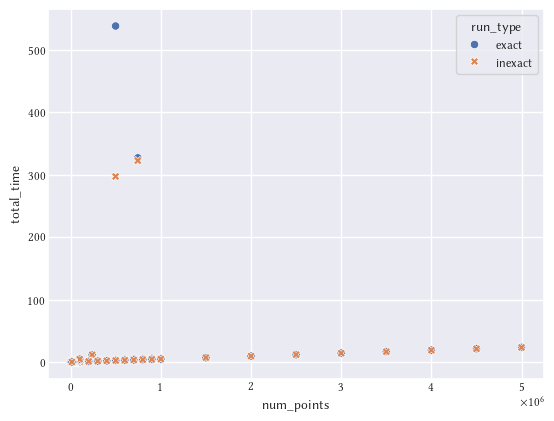

In [13]:
sns.scatterplot(average_out_total_times(public_set), x="num_points", y="total_time", hue="run_type", style="run_type")

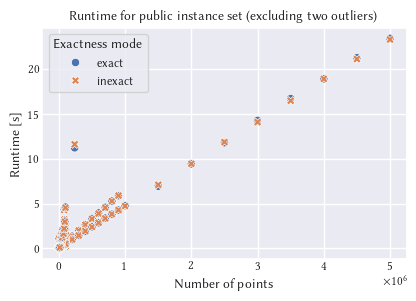

In [14]:
sns.scatterplot(average_out_total_times(public_set[(public_set["instance_name"] != "lra498378") & (public_set["instance_name"] != "lrb744710")]), hue="run_type", style="run_type", x="num_points", y="total_time")

plt.xlabel("Number of points")
plt.ylabel("Runtime [s]")
plt.gcf().set_size_inches(4.7, 3)
plt.gca().get_legend().set_title("Exactness mode")
plt.gca().set_title("Runtime for public instance set (excluding two outliers)")
plt.savefig("public_set_runtime_excluding_outliers.pdf")

KeyboardInterrupt: 

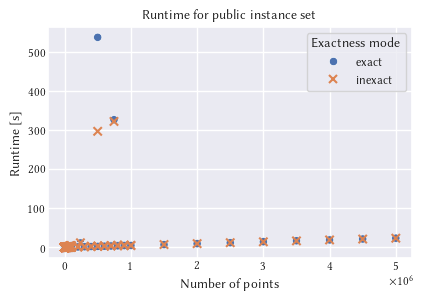

In [15]:
ax = plt.gca()
sns.scatterplot(average_out_total_times(
    public_set[public_set["run_type"] == "exact"]), 
    hue="run_type", style="run_type", x="num_points", y="total_time", 
    ax=ax, palette=["C0"], zorder=10, markers=["o"])
sns.scatterplot(average_out_total_times(
    public_set[public_set["run_type"] == "inexact"]), 
    hue="run_type", style="run_type", x="num_points", y="total_time", 
    ax=ax, palette=["C1"], zorder=15, markers=["x"], linewidth=1.5)
plt.xlabel("Number of points")
plt.ylabel("Runtime [s]")
plt.gca().get_legend().set_title("Exactness mode")
plt.gca().set_title("Runtime for public instance set")
plt.gcf().set_size_inches(4.7, 3)
plt.savefig("public_set_runtime_all.pdf")

<Axes: xlabel='num_points', ylabel='total_time'>

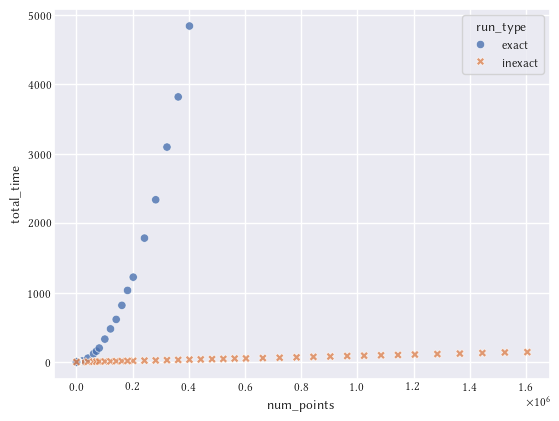

In [ ]:
sns.scatterplot(average_out_total_times(evolved), hue="run_type", style="run_type", x="num_points", y="total_time", alpha=0.8)

In [ ]:
evolved[evolved["run_succeeded"] == True].sort_values("total_time").iloc[-1]["face_triangulation_stats"]

{'nonsimple_faces': [{'exact_coefficient_initialization_time': 2.7356270900000004,
   'exact_dual_infeasibility_computations': 1,
   'exact_simplex_iterations': 4319,
   'exact_simplex_time': 4894.841927681,
   'exact_startup_time': 3.953193299,
   'face_analysis_time': 1.3692562050000001,
   'imprecise_lp_solve_time': 20.833574939000002,
   'imprecise_model_creation_time': 2.8075684080000003,
   'imprecise_solve_stats': {'barrier_iterations': 14,
    'condition_estimate': 160.00000000000009,
    'num_constraints': 1559974,
    'num_nonzeros': 7164961,
    'num_variables': 3238750,
    'obj_value': 56852622.01210159,
    'runtime': 20.801801919937134,
    'simplex_iterations': 460971.0},
   'initial_interval_dual_feasibility_check_time': 0.23423908200000002,
   'intervals_show_inexact_lp_was_optimal': False,
   'num_triangle_vars': 3238750,
   'rank_reduction_time': 4.570005199000001,
   'rows_after_reduction': 1559974,
   'rows_before_reduction': 1981163,
   'symbolic_objective_coeffi

In [ ]:
average_out_total_times(odd_wheels.query("max_relative_gap > 0")).sort_values("max_relative_gap")

,,instance_dir,run_index,run_succeeded,run_failure_type,advanced_lmt_candidate_edges,advanced_lmt_fixed_edges,advanced_lmt_time,diamond_time,edges_passing_diamond_filter,face_triangulation_stats,face_triangulation_time,gen_time,instance_file,lmt_candidate_edges,lmt_fixed_edges,lmt_time,max_gap,max_resource_usage,num_points,total_weight_lb,total_weight_ub,verification_mode,max_res_involuntary_context_switches,max_res_major_page_faults,max_res_max_resident_set_size,max_res_minor_page_faults,max_res_process_system_time,max_res_process_user_time,max_res_resident_set_size,max_res_swap_usage,max_res_voluntary_context_switches,max_res_total_memory,num_nonsimple_faces,total_time,max_relative_gap,min_total_time,max_total_time,total_time_dev,is_uniform_random,instance_class
instance_name,run_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
regpoly_223,inexact,./02_raw_output/odd_wheels,4,1.0,NaN,8251.0,223.0,0.115066,0.021426,17878.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",91.520862,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,8251.0,223.0,0.173121,0.005415,"{'involuntary_context_switches': 463, 'major_p...",224.0,44.391875,44.391875,none,486.4,0.4,8.995422e+08,412096.0,2.307948,197.774447,8.981332e+08,0.0,26731.6,8.995422e+08,1.0,91.830475,0.000122,90.812055,93.364669,0.028109,0.0,odd wheels
regpoly_193,inexact,./02_raw_output/odd_wheels,4,1.0,NaN,6176.0,193.0,0.070675,0.016154,13520.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",20.481825,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,6176.0,193.0,0.115388,0.006343,"{'involuntary_context_switches': 143, 'major_p...",194.0,43.362046,43.362046,none,132.4,0.0,6.736355e+08,293434.8,1.496484,54.226446,6.649905e+08,0.0,7104.8,6.736355e+08,1.0,20.684042,0.000146,20.239418,21.088399,0.041947,0.0,odd wheels
regpoly_321,inexact,./02_raw_output/odd_wheels,1,1.0,NaN,17013.0,321.0,0.372845,0.048826,36812.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",46.936119,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,17013.0,321.0,0.624466,0.006990,"{'involuntary_context_switches': 365, 'major_p...",322.0,47.600973,47.600973,none,387.4,1.8,1.803374e+09,1558519.2,9.695180,217.608358,1.798040e+09,0.0,286222.8,1.803374e+09,1.0,47.982256,0.000147,46.466447,49.647642,0.068462,0.0,odd wheels
regpoly_191,inexact,./02_raw_output/odd_wheels,2,1.0,NaN,5921.0,191.0,0.070233,0.015494,12992.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",19.393510,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,5921.0,191.0,0.108645,0.006648,"{'involuntary_context_switches': 144, 'major_p...",192.0,43.263733,43.263733,none,143.6,1.4,5.947769e+08,256608.0,2.921864,57.340725,5.931975e+08,0.0,15701.6,5.947769e+08,1.0,19.587881,0.000154,19.486001,19.713343,0.011667,0.0,odd wheels
regpoly_177,inexact,./02_raw_output/odd_wheels,4,1.0,NaN,5133.0,177.0,0.059267,0.014699,11282.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",8.696215,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,5133.0,177.0,0.080487,0.007049,"{'involuntary_context_switches': 65, 'major_pa...",178.0,42.373342,42.373342,none,72.2,9.0,4.689674e+08,174457.8,1.196167,25.164658,4.687430e+08,0.0,5409.4,4.689674e+08,1.0,8.850668,0.000166,8.575292,9.075574,0.058340,0.0,odd wheels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
regpoly_67,inexact,./02_raw_output/odd_wheels,4,1.0,NaN,737.0,67.0,0.003098,0.002219,1631.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",0.189624,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,737.0,67.0,0.004749,0.155696,"{'involuntary_context_switches': 33, 'major_pa...",68.0,33.468836,33.468836,none,31.4,0.6,6.364611e+07,12939.2,0.122395,0.710294,6.350766e+07,0.0,145.0,6.364611e+07,1.0,0.199691,0.004652,0.183657,0.242524,0.320529,0.0,odd wheels
regpoly_15,inexact,./02_raw_output/odd_wheels,5,1.0,NaN,30.0,15.0,0.000005,0.000359,90.0,"{'nonsimple_faces': [{'

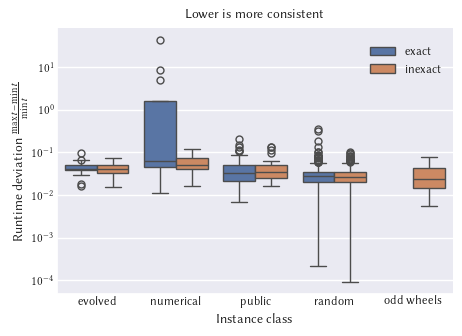

In [ ]:
fig = sns.catplot(data=dataframe.query("max_total_time > 1 and run_succeeded == True and run_index=='1'"),
                  x="instance_class", hue="run_type", y="total_time_dev", kind='box')
fig.ax.set_yscale('log')
fig.ax.set_title("Lower is more consistent")
fig.ax.set_xlabel("Instance class")
fig.ax.set_ylabel("Runtime deviation $\\frac{\\max t - \\min t}{\\min t}$")
fig.figure.set_size_inches(5.2, 3)
fig.legend.set_title(None)
sns.move_legend(fig, "upper right", bbox_to_anchor=(0.85, 0.95))
fig.savefig("runtime_consistency.pdf")

# Number of random instances needing LP

In [ ]:
random[random["face_triangulation_stats"].notnull()]["instance_name"].unique()

array(['uniform-40000000-6', 'uniform-73000000-0', 'uniform-52000000-0',
       'uniform-91000000-0'], dtype=object)

# Number of public instances needing LP

In [ ]:
public_set[public_set["face_triangulation_stats"].notnull()]["instance_name"].unique()

array(['many_holes_2_9', 'many_holes_4_6', 'many_holes_3_0',
       'many_holes_3_9', 'many_holes_2_5', 'many_holes_5_9',
       'many_holes_3_3', 'many_holes_1_7', 'many_holes_1_9',
       'many_holes_2_2', 'many_holes_2_0', 'many_holes_3_4',
       'many_holes_1_5', 'many_holes_2_6', 'many_holes_2_7', 'lra498378',
       'many_holes_3_2', 'many_holes_4_8', 'euro-night-0090000',
       'many_holes_5_0', 'many_holes_4_4', 'many_holes_5_6',
       'many_holes_5_1', 'many_holes', 'many_holes_2_1', 'many_holes_2_3',
       'many_holes_5_2', 'many_holes_5_5', 'many_holes_4_1',
       'many_holes_1_3', 'many_holes_4_0', 'many_holes_3_7',
       'many_holes_3_6', 'many_holes_1_0', 'many_holes_5_4',
       'many_holes_3_5', 'many_holes_5_8', 'many_holes_4_5',
       'many_holes_3_8', 'many_holes_5_3', 'many_holes_1_6',
       'many_holes_1_1', 'many_holes_1_4', 'many_holes_3_1',
       'many_holes_1_8', 'many_holes_5_7', 'many_holes_2_8',
       'many_holes_4_3', 'many_holes_1_2', 'many_holes

# Slow public benchmark set instances

In [ ]:
public_set.query("total_time > 150")

,instance_name,instance_dir,run_type,run_index,run_succeeded,run_failure_type,advanced_lmt_candidate_edges,advanced_lmt_fixed_edges,advanced_lmt_time,diamond_time,edges_passing_diamond_filter,face_triangulation_stats,face_triangulation_time,gen_time,instance_file,lmt_candidate_edges,lmt_fixed_edges,lmt_time,max_gap,max_resource_usage,num_points,total_weight_lb,total_weight_ub,verification_mode,max_res_involuntary_context_switches,max_res_major_page_faults,max_res_max_resident_set_size,max_res_minor_page_faults,max_res_process_system_time,max_res_process_user_time,max_res_resident_set_size,max_res_swap_usage,max_res_voluntary_context_switches,max_res_total_memory,num_nonsimple_faces,total_time,max_relative_gap,min_total_time,max_total_time,total_time_dev,is_uniform_random,instance_class
84809,lrb744710,./02_raw_output/public_instance_set,exact,1,True,None,1073199.0,1879647.0,325.775151,3.746410,8948702.0,None,0.579418,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,1233436.0,1872986.0,2.443090,0.000000,"{'involuntary_context_switches': 2146, 'major_...",744710,9.097450e+06,9.097450e+06,none,2146.0,0.0,1.239216e+09,343830.0,3.339195,394.416973,1.235878e+09,0.0,19161.0,1.239216e+09,0.0,332.544069,0.000000e+00,313.050440,332.544069,0.062270,False,public
85041,lra498378,./02_raw_output/public_instance_set,exact,1,True,None,1061439.0,1209111.0,216.338828,51.823919,7987760.0,{'nonsimple_faces': [{'exact_coefficient_initi...,269.133586,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,1214570.0,1204368.0,4.918960,0.000000,"{'involuntary_context_switches': 2949, 'major_...",498378,1.560253e+07,1.560253e+07,none,2949.0,0.0,4.222627e+10,16373254.0,40.105992,907.197470,4.222627e+10,0.0,84826.0,4.222627e+10,1.0,542.215295,0.000000e+00,533.588566,542.215295,0.016167,False,public
85258,lra498378,./02_raw_output/public_instance_set,inexact,4,True,None,1061439.0,1209111.0,214.409139,52.322247,7987760.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",27.888133,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,1214570.0,1204368.0,4.961823,0.000013,"{'involuntary_context_switches': 1759, 'major_...",498378,1.560253e+07,1.560253e+07,none,1759.0,0.0,4.007817e+09,2144506.0,20.928594,622.747746,4.006879e+09,0.0,96277.0,4.007817e+09,1.0,299.581343,8.638966e-13,293.447883,302.480052,0.030779,False,public
85316,lrb744710,./02_raw_output/public_instance_set,exact,4,True,None,1073199.0,1879647.0,324.270351,3.794176,8948702.0,None,0.582373,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,1233436.0,1872986.0,2.406157,0.000000,"{'involuntary_context_switches': 1711, 'major_...",744710,9.097450e+06,9.097450e+06,none,1711.0,0.0,1.219539e+09,340638.0,3.451551,393.860864,1.210188e+09,0.0,19120.0,1.219539e+09,0.0,331.053056,0.000000e+00,313.050440,332.544069,0.062270,False,public
85593,lra498378,./02_raw_output/public_instance_set,exact,3,True,None,1061439.0,1209111.0,220.017349,51.676259,7987760.0,{'nonsimple_faces': [{'exact_coefficient_initi...,260.981212,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,1214570.0,1204368.0,4.970079,0.000000,"{'involuntary_context_switches': 2935, 'major_...",498378,1.560253e+07,1.560253e+07,none,2935.0,1.0,4.237896e+10,14438649.0,38.634189,926.348232,4.237896e+10,0.0,116258.0,4.237896e+10,1.0,537.644899,0.000000e+00,533.588566,542.215295,0.016167,False,public
85872,lra498378,./02_raw_output/public_instance_set,inexact,1,True,None,1061439.0,1209111.0,207.348692,54.190258,7987760.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",29.687788,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,1214570.0,1204368.0,4.922423,0.000014,"{'involuntary_context_switches': 1919, 'major_...",498378,1.560253e+07,1.560253e+07,none,1919.0,0.0,4.107895e+09,2166671.0,22.696184,621.184444,4.107895e+09,0.0,93009.0,4.107895e+09,1.0,296.149161,8.880376e-13,293.447883,302.480052,0.030779,False,public
85882,lrb744710,./02_raw_output/public_instance_set,exact,3,True,None,1073199.0,1879647.0,323.709984,3.792317,8948

In [ ]:
hole_triang_data = list(public_set.query("face_triangulation_time > 100")["face_triangulation_stats"].values)

In [ ]:
hole_triang_data[0]['nonsimple_faces'][0]

{'exact_coefficient_initialization_time': 0.14141763100000002,
 'exact_dual_infeasibility_computations': 1,
 'exact_simplex_iterations': 0,
 'exact_simplex_time': 4.602e-05,
 'exact_startup_time': 0.041028341,
 'face_analysis_time': 0.039536408,
 'imprecise_lp_solve_time': 1.667351542,
 'imprecise_model_creation_time': 0.135846389,
 'imprecise_solve_stats': {'barrier_iterations': 0,
  'condition_estimate': 2755.999999999999,
  'num_constraints': 24913,
  'num_nonzeros': 533026,
  'num_variables': 188071,
  'obj_value': 605516.552377695,
  'runtime': 1.6667230129241943,
  'simplex_iterations': 17377.0},
 'initial_interval_dual_feasibility_check_time': 0.011977195000000001,
 'intervals_show_inexact_lp_was_optimal': False,
 'num_triangle_vars': 188071,
 'rank_reduction_time': 1.705255927,
 'rows_after_reduction': 24913,
 'rows_before_reduction': 25956,
 'symbolic_objective_coefficient_initialization_time': 1.491287011}

In [ ]:
hole_triang_data[0]['nonsimple_faces'][1]

{'exact_coefficient_initialization_time': 0.7120627860000001,
 'exact_dual_infeasibility_computations': 1,
 'exact_simplex_iterations': 0,
 'exact_simplex_time': 0.02559789,
 'exact_startup_time': 0.30771537600000004,
 'face_analysis_time': 0.31740444,
 'imprecise_lp_solve_time': 29.840525886,
 'imprecise_model_creation_time': 0.58243884,
 'imprecise_solve_stats': {'barrier_iterations': 66,
  'condition_estimate': 99644.00000000164,
  'num_constraints': 117678,
  'num_nonzeros': 2565753,
  'num_variables': 890165,
  'obj_value': 2430391.4165400737,
  'runtime': 29.837446928024292,
  'simplex_iterations': 112684.0},
 'initial_interval_dual_feasibility_check_time': 0.04576183,
 'intervals_show_inexact_lp_was_optimal': False,
 'num_triangle_vars': 890165,
 'rank_reduction_time': 74.467209877,
 'rows_after_reduction': 117678,
 'rows_before_reduction': 119860,
 'symbolic_objective_coefficient_initialization_time': 155.335891408}

# Evolved instances

In [ ]:
evolved_exact_solved = evolved.query("run_succeeded == True and run_type == 'exact'")
evolved_exact_solved.sort_values("num_points")

,instance_name,instance_dir,run_type,run_index,run_succeeded,run_failure_type,advanced_lmt_candidate_edges,advanced_lmt_fixed_edges,advanced_lmt_time,diamond_time,edges_passing_diamond_filter,face_triangulation_stats,face_triangulation_time,gen_time,instance_file,lmt_candidate_edges,lmt_fixed_edges,lmt_time,max_gap,max_resource_usage,num_points,total_weight_lb,total_weight_ub,verification_mode,max_res_involuntary_context_switches,max_res_major_page_faults,max_res_max_resident_set_size,max_res_minor_page_faults,max_res_process_system_time,max_res_process_user_time,max_res_resident_set_size,max_res_swap_usage,max_res_voluntary_context_switches,max_res_total_memory,num_nonsimple_faces,total_time,max_relative_gap,min_total_time,max_total_time,total_time_dev,is_uniform_random,instance_class
80495,different_hole_counts_r1_1,./02_raw_output/evolved_instances,exact,1,True,None,378.0,94.0,0.000397,0.000700,721.0,{'nonsimple_faces': [{'exact_coefficient_initi...,0.025174,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,378.0,94.0,0.004550,0.0,"{'involuntary_context_switches': 0, 'major_pag...",64,7.584793e+03,7.584793e+03,none,0.0,0.0,1.639219e+07,1814.0,0.017160,0.011440,1.639219e+07,0.0,139.0,1.639219e+07,1.0,0.030821,0.0,0.006775,0.030821,3.549197,False,evolved
76325,different_hole_counts_r1_1,./02_raw_output/evolved_instances,exact,2,True,None,378.0,94.0,0.000280,0.000717,721.0,{'nonsimple_faces': [{'exact_coefficient_initi...,0.005081,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,378.0,94.0,0.000697,0.0,"{'involuntary_context_switches': 0, 'major_pag...",64,7.584793e+03,7.584793e+03,none,0.0,0.0,1.660109e+07,1925.0,0.015480,0.002667,1.660109e+07,0.0,153.0,1.660109e+07,1.0,0.006775,0.0,0.006775,0.030821,3.549197,False,evolved
69842,different_hole_counts_r1_1,./02_raw_output/evolved_instances,exact,5,True,None,378.0,94.0,0.000262,0.000729,721.0,{'nonsimple_faces': [{'exact_coefficient_initi...,0.023518,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,378.0,94.0,0.000584,0.0,"{'involuntary_context_switches': 153, 'major_p...",64,7.584793e+03,7.584793e+03,none,153.0,0.0,1.654784e+07,1905.0,0.014846,0.002806,1.654784e+07,0.0,128.0,1.654784e+07,1.0,0.025094,0.0,0.006775,0.030821,3.549197,False,evolved
62370,different_hole_counts_r1_1,./02_raw_output/evolved_instances,exact,4,True,None,378.0,94.0,0.000475,0.001386,721.0,{'nonsimple_faces': [{'exact_coefficient_initi...,0.007130,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,378.0,94.0,0.000945,0.0,"{'involuntary_context_switches': 49, 'major_pa...",64,7.584793e+03,7.584793e+03,none,49.0,0.0,1.658061e+07,1889.0,0.018195,0.002506,1.658061e+07,0.0,179.0,1.658061e+07,1.0,0.009936,0.0,0.006775,0.030821,3.549197,False,evolved
6136,different_hole_counts_r1_1,./02_raw_output/evolved_instances,exact,3,True,None,378.0,94.0,0.000282,0.000808,721.0,{'nonsimple_faces': [{'exact_coefficient_initi...,0.005324,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,378.0,94.0,0.000403,0.0,"{'involuntary_context_switches': 0, 'major_pag...",64,7.584793e+03,7.584793e+03,none,0.0,0.0,1.653555e+07,1682.0,0.006086,0.006086,1.653555e+07,0.0,36.0,1.653555e+07,1.0,0.006817,0.0,0.006775,0.030821,3.549197,False,evolved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70262,different_hole_counts_r100_100,./02_raw_output/evolved_instances,exact,1,True,None,3801475.0,364909.0,2.424934,0.545125,6789643.0,{'nonsimple_faces': [{'exact_coefficient_initi...,4850.533080,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,3801475.0,364909.0,1.129754,0.0,"{'involuntary_context_switches': 21064, 'major...",402202,4.359637e+07,4.359637e+07,none,21064.0,0.0,2.248377e+10,10656453.0,19.187901,4910.782724,2.248377e+10,0.0,71030.0,2.248377e+10,1.0,4854.632893,0.0,4720.566833,4939.113306,0.046297,False,evolved
52572,different_hole_counts_r100_100,./02_raw_output/evolved_instances,e

Text(0, 0.5, 'Memory usage [Bytes]')

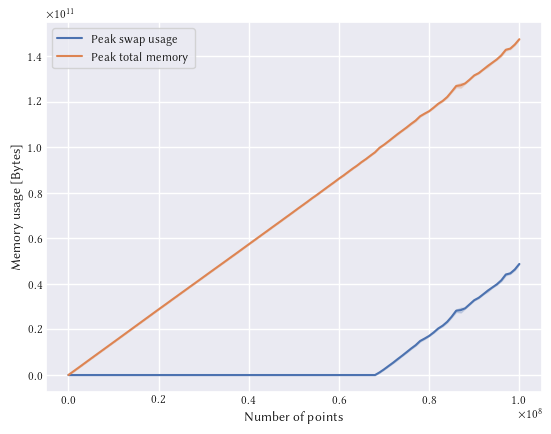

In [ ]:
s = sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_swap_usage", label="Peak swap usage")
sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_total_memory", label="Peak total memory")
for label in s.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
s.set_xlabel("Number of points")
s.set_ylabel("Memory usage [Bytes]")

Text(0, 0.5, 'Memory usage [Bytes]')

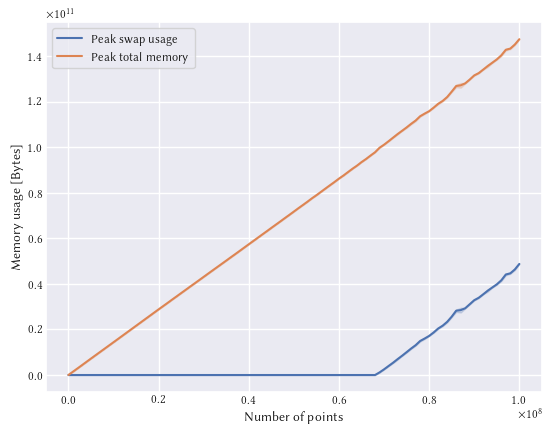

In [ ]:
s = sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_swap_usage", label="Peak swap usage")
sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_total_memory", label="Peak total memory")
for label in s.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
s.set_xlabel("Number of points")
s.set_ylabel("Memory usage [Bytes]")

Text(0, 0.5, 'Memory usage [Bytes]')

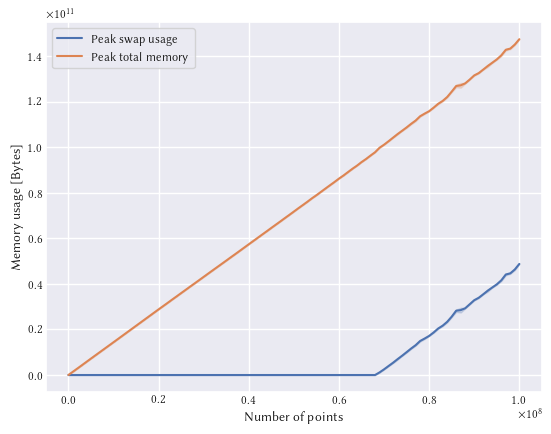

In [ ]:
s = sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_swap_usage", label="Peak swap usage")
sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_total_memory", label="Peak total memory")
for label in s.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
s.set_xlabel("Number of points")
s.set_ylabel("Memory usage [Bytes]")

Text(0, 0.5, 'Memory usage [Bytes]')

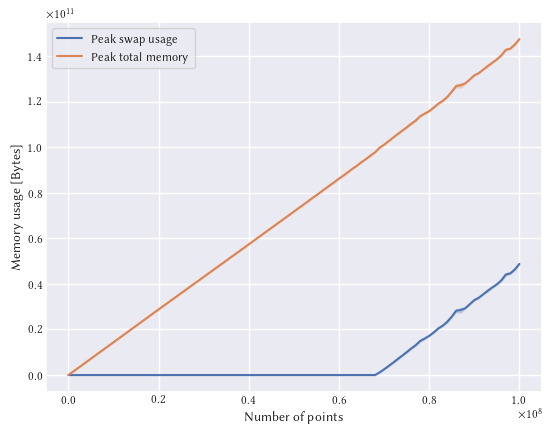

In [ ]:
s = sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_swap_usage", label="Peak swap usage")
sns.lineplot(uniform[uniform["run_type"] == "exact"], x="num_points", y="max_res_total_memory", label="Peak total memory")
for label in s.get_legend().get_texts():
    if label.get_text() in text_remap:
        label.set_text(text_remap[label.get_text()])
s.set_xlabel("Number of points")
s.set_ylabel("Memory usage [Bytes]")

# Numerical instances

In [ ]:
face_triangulation_stats = list(numerical.query("instance_name == 'distant_clusters_90000' & run_type == 'exact' & run_succeeded == True")["face_triangulation_stats"].values)

In [ ]:
[len(run["nonsimple_faces"]) for run in face_triangulation_stats]

[]

In [ ]:
[max((face for face in run["nonsimple_faces"]), key=lambda f: f['exact_simplex_time']) for run in face_triangulation_stats]

[]

# Instances exactly solved


In [ ]:
successful_exact_runs = dataframe.query("run_succeeded == True & run_type =='exact'")
instance_to_exact_runs = {}
for row in successful_exact_runs.itertuples(name="RowTuple"):
    e = instance_to_exact_runs.setdefault(row.instance_name, {"instance_dir": row.instance_dir, "runs": []})
    e["runs"].append(int(row.run_index))
with open("05a_successful_exact_solves.json", "w") as f:
    json.dump(instance_to_exact_runs, f, indent=2)

# Errors and Error Bounds

## Load comparison data

In [ ]:
inexact_comparison_jsonl = "./09_compared_inexact_to_exact.jsonl.bz2"
with bz2.open(inexact_comparison_jsonl, "rt") as f:
    inexact_comparison_data = [json.loads(line) for line in f]
run_decomp_re = re.compile("^[.]/02_raw_output/([^/]+)/([^/]+)_inexact_run([0-9]+)[.]json[.]bz2$")
for element in inexact_comparison_data:
    m = run_decomp_re.match(element["inexact_run"])
    if not m:
        raise RuntimeError("Could not match", element["inexact_run"])
    element["instance_class"] = m.group(1)
    element["instance_name"] = m.group(2)
    element["run_index"] = int(m.group(3))
inexact_comparison_dataframe = pd.DataFrame(inexact_comparison_data)
inexact_comparison_dataframe

,error,stdout,stderr,exit_code,difference_lb,difference_ub,exact_run,inexact_run,instance_class,instance_name,run_index
0,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/evolved_instances/o20190827_14...,./02_raw_output/evolved_instances/o20190827_14...,evolved_instances,o20190827_143536_76_hard_instances_1_p0_p0,2
1,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/evolved_instances/20190827_143...,./02_raw_output/evolved_instances/20190827_143...,evolved_instances,20190827_143636_93_hard_instances_0_p7,1
2,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/evolved_instances/20190827_143...,./02_raw_output/evolved_instances/20190827_143...,evolved_instances,20190827_143636_11_hard_instances_9_p4,2
3,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/evolved_instances/o20190827_14...,./02_raw_output/evolved_instances/o20190827_14...,evolved_instances,o20190827_143636_26_hard_instances_1_p4_p1,3
4,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/evolved_instances/20190827_143...,./02_raw_output/evolved_instances/20190827_143...,evolved_instances,20190827_143536_1_hard_instances_1_p0,4
...,...,...,...,...,...,...,...,...,...,...,...
48252,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/random/uniform-2500000-2_exact...,./02_raw_output/random/uniform-2500000-2_inexa...,random,uniform-2500000-2,3
48253,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/random/uniform-69000000-0_exac...,./02_raw_output/random/uniform-69000000-0_inex...,random,uniform-69000000-0,2
48254,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/random/uniform-57000000-0_exac...,./02_raw_output/random/uniform-57000000-0_inex...,random,uniform-57000000-0,1
48255,False,The triangulations are exactly the same.\nInte...,,0,0.0,0.0,./02_raw_output/random/uniform-70000000-0_exac...,./02_raw_output/random/uniform-70000000-0_inex...,random,uniform-70000000-0,1


In [ ]:
public_set.query("run_type == 'inexact' & max_gap > 0").sort_values("instance_name")[["instance_name", "max_gap", "max_relative_gap", "total_weight_lb"]]
public_instances_with_gaps = public_set.query("run_type == 'inexact' & max_gap > 0")["instance_name"].unique()
public_instances_with_gaps = list(public_instances_with_gaps)

In [ ]:
def rewrite_float(float):
    if float == 0.0:
        return '0'
    s = str(float)
    m = re.match("^(-?)([0-9])[.]([0-9]+)[eE]-([0-9]+)$", s)
    if not m:
        raise RuntimeError("Could not match", s)
    sign = m.group(1)
    mag = m.group(2) + m.group(3)
    exp = int(m.group(4))
    mag5 = int(mag[:5])
    mag5 += 1
    return f"{sign}{str(mag5)[0]}.{str(mag5)[1:]} \\cdot 10^{{{-exp}}}"

In [ ]:
import subprocess
import os
import math


def rerun_comparison_precise_interval(exact_run, inexact_run):
    exefile = "../../build/Release/src/compare_triangulations"
    if not os.path.isfile(exefile) or not os.path.isfile(exact_run) or not os.path.isfile(inexact_run):
        raise RuntimeError("Could not find required files")
    res = subprocess.run([exefile, "-i", exact_run, "-j", inexact_run, "--precise-interval-difference"],
                         capture_output=True, text=True, check=True)
    for line in res.stdout.splitlines():
        if not line.startswith("Interval difference: "): continue
        m = re.match("^Interval difference: \[([0-9eE.+-]+), ([0-9eE.+-]+)\]$", line)
        if not m:
            raise RuntimeError("Could not parse interval difference")
        return (-float(m.group(2)), -float(m.group(1)))
    raise RuntimeError("Could not find interval difference in output")


for instance_name in sorted(public_instances_with_gaps):
    if not instance_name.startswith("many_holes"): continue
    inexact_runs = inexact_comparison_dataframe.query(f"instance_name == '{instance_name}'")
    max_error_lb = 0.0
    max_error_ub = 0.0
    for row in inexact_runs.itertuples():
        exact_run = row.exact_run
        inexact_run = row.inexact_run
        lb, ub = rerun_comparison_precise_interval(exact_run, inexact_run)
        if lb > max_error_lb:
            max_error_lb = lb
        if ub > max_error_ub:
            max_error_ub = ub
    inexact_results = public_set.query(f"run_type == 'inexact' and instance_name == '{instance_name}'")[["max_gap", "max_relative_gap", "total_weight_lb"]]
    max_gap = 0.0
    max_relative_gap = 0.0
    weight_lb = math.inf
    for row in inexact_results.itertuples():
        if row.max_gap > max_gap:
            max_gap = row.max_gap
        if row.max_relative_gap > max_relative_gap:
            max_relative_gap = row.max_relative_gap
        if row.total_weight_lb < weight_lb:
            weight_lb = row.total_weight_lb
    max_error_rel = max_error_ub / weight_lb
    fixed_iname = instance_name.replace('_', '\\_')
    print(f"\\texttt{{{fixed_iname}}} & ${rewrite_float(max_gap)}$ & ${rewrite_float(max_relative_gap)}$ & ${rewrite_float(max_error_ub)}$ & ${rewrite_float(max_error_rel)}$ \\\\")


<>:14: SyntaxWarning:

invalid escape sequence '\['

<>:14: SyntaxWarning:

invalid escape sequence '\['

/var/folders/wd/nrcjx5551993mcd3k2sq9c580000gn/T/ipykernel_50037/1696824511.py:14: SyntaxWarning:

invalid escape sequence '\['



\texttt{many\_holes} & $1.1533 \cdot 10^{-9}$ & $3.1512 \cdot 10^{-14}$ & $4.3515 \cdot 10^{-14}$ & $1.1891 \cdot 10^{-18}$ \\
\texttt{many\_holes\_1\_0} & $2.7740 \cdot 10^{-11}$ & $6.4254 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_1} & $3.0469 \cdot 10^{-11}$ & $6.9159 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_2} & $2.3193 \cdot 10^{-11}$ & $5.3301 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_3} & $3.2288 \cdot 10^{-11}$ & $7.3851 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_4} & $3.1378 \cdot 10^{-11}$ & $7.3750 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_5} & $2.5012 \cdot 10^{-11}$ & $5.7607 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_6} & $2.3647 \cdot 10^{-11}$ & $5.4028 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_7} & $5.6389 \cdot 10^{-11}$ & $1.3090 \cdot 10^{-15}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_8} & $3.4561 \cdot 10^{-11}$ & $7.3667 \cdot 10^{-16}$ & $0$ & $0$ \\
\texttt{many\_holes\_1\_9} 

In [ ]:
inexact_comparison_dataframe.query("instance_name == 'many_holes'")

,error,stdout,stderr,exit_code,difference_lb,difference_ub,exact_run,inexact_run,instance_class,instance_name,run_index
40860,False,The better triangulation is strictly better th...,,0,-7.105427e-14,4.263256e-14,./02_raw_output/public_instance_set/many_holes...,./02_raw_output/public_instance_set/many_holes...,public_instance_set,many_holes,1
40861,False,The better triangulation is strictly better th...,,0,-7.105427e-14,4.263256e-14,./02_raw_output/public_instance_set/many_holes...,./02_raw_output/public_instance_set/many_holes...,public_instance_set,many_holes,2
40862,False,The better triangulation is strictly better th...,,0,-7.105427e-14,4.263256e-14,./02_raw_output/public_instance_set/many_holes...,./02_raw_output/public_instance_set/many_holes...,public_instance_set,many_holes,3
40863,False,The better triangulation is strictly better th...,,0,-7.105427e-14,4.263256e-14,./02_raw_output/public_instance_set/many_holes...,./02_raw_output/public_instance_set/many_holes...,public_instance_set,many_holes,4
40864,False,The better triangulation is strictly better th...,,0,-7.105427e-14,4.263256e-14,./02_raw_output/public_instance_set/many_holes...,./02_raw_output/public_instance_set/many_holes...,public_instance_set,many_holes,5


In [ ]:
inexact_comparison_dataframe.query("instance_name == 'distant_clusters_2000'")

,error,stdout,stderr,exit_code,difference_lb,difference_ub,exact_run,inexact_run,instance_class,instance_name,run_index
39718,False,The better triangulation is strictly better th...,,0,-0.000001,-6.556511e-07,./02_raw_output/numerically_difficult/distant_...,./02_raw_output/numerically_difficult/distant_...,numerically_difficult,distant_clusters_2000,4
40606,False,The better triangulation is strictly better th...,,0,-0.000001,-6.556511e-07,./02_raw_output/numerically_difficult/distant_...,./02_raw_output/numerically_difficult/distant_...,numerically_difficult,distant_clusters_2000,5
42135,False,The better triangulation is strictly better th...,,0,-0.000001,-6.556511e-07,./02_raw_output/numerically_difficult/distant_...,./02_raw_output/numerically_difficult/distant_...,numerically_difficult,distant_clusters_2000,1
43287,False,The better triangulation is strictly better th...,,0,-0.000001,-6.556511e-07,./02_raw_output/numerically_difficult/distant_...,./02_raw_output/numerically_difficult/distant_...,numerically_difficult,distant_clusters_2000,3
44351,False,The better triangulation is strictly better th...,,0,-0.000001,-6.556511e-07,./02_raw_output/numerically_difficult/distant_...,./02_raw_output/numerically_difficult/distant_...,numerically_difficult,distant_clusters_2000,2


In [ ]:
evolved_with_gap = evolved.query("run_type == 'inexact' & max_gap > 0")
total_weight_lb_data = {}
for row in evolved_with_gap.itertuples():
    prev = total_weight_lb_data.get(row.instance_name, math.inf)
    total_weight_lb_data[row.instance_name] = min(row.total_weight_lb, prev)
evolved_instance_name_with_total_weight_lb = pd.DataFrame([{"instance_name": k, "total_weight_lb": v} for k, v in total_weight_lb_data.items()])
evolved_error_with_gap = inexact_comparison_dataframe[inexact_comparison_dataframe["instance_name"].isin(evolved_with_gap["instance_name"])]
evolved_error_with_gap = pd.merge(evolved_error_with_gap, evolved_instance_name_with_total_weight_lb, left_on="instance_name", right_on="instance_name")
evolved_error_with_gap["absolute_error"] = -evolved_error_with_gap["difference_lb"]
evolved_error_with_gap["relative_error"] = evolved_error_with_gap["absolute_error"] / evolved_error_with_gap["total_weight_lb"]
evolved_error_with_gap = pd.merge(evolved_error_with_gap, instance_dataframe, left_on="instance_name", right_on="instance_name")

In [ ]:
numerical_with_gap = numerical.query("run_type == 'inexact' & max_gap > 0")
total_weight_lb_data = {}
for row in numerical_with_gap.itertuples():
    prev = total_weight_lb_data.get(row.instance_name, math.inf)
    total_weight_lb_data[row.instance_name] = min(row.total_weight_lb, prev)
numerical_instance_name_with_total_weight_lb = pd.DataFrame([{"instance_name": k, "total_weight_lb": v} for k, v in total_weight_lb_data.items()])
numerical_error_with_gap = inexact_comparison_dataframe[inexact_comparison_dataframe["instance_name"].isin(numerical_with_gap["instance_name"])]
numerical_error_with_gap = pd.merge(numerical_error_with_gap, numerical_instance_name_with_total_weight_lb, left_on="instance_name", right_on="instance_name")
numerical_error_with_gap["absolute_error"] = -numerical_error_with_gap["difference_lb"]
numerical_error_with_gap["relative_error"] = numerical_error_with_gap["absolute_error"] / numerical_error_with_gap["total_weight_lb"]
numerical_error_with_gap = pd.merge(numerical_error_with_gap, instance_dataframe, left_on="instance_name", right_on="instance_name")


In [ ]:
odd_wheels_with_gap = odd_wheels.query("run_type == 'inexact' & max_gap > 0")

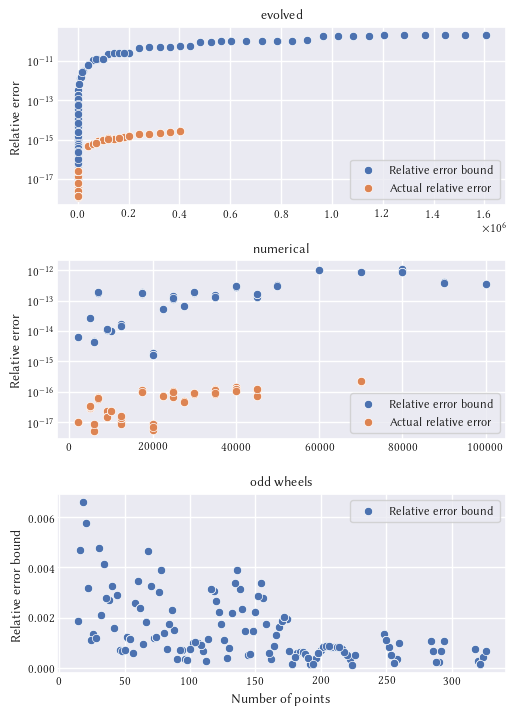

In [ ]:
fig, (axev, axnum, axodd) = plt.subplots(3, 1)
fig.set_size_inches(5.2, 7.2)

sns.scatterplot(data=evolved_with_gap, x="num_points", y="max_relative_gap", label="Relative error bound", ax=axev)
sns.scatterplot(data=evolved_error_with_gap, x="num_points", y="relative_error", label="Actual relative error", ax=axev)
axev.set_yscale('log')
axev.set_xlabel(None)
axev.set_ylabel("Relative error")
axev.set_title("evolved")

sns.scatterplot(data=numerical_with_gap, x="num_points", y="max_relative_gap", label="Relative error bound", ax=axnum)
sns.scatterplot(data=numerical_error_with_gap, x="num_points", y="relative_error", label="Actual relative error", ax=axnum)
axnum.set_yscale('log')
axnum.set_xlabel(None)
axnum.set_ylabel("Relative error")
axnum.set_title("numerical")


sns.scatterplot(data=odd_wheels_with_gap, x="num_points", y="max_relative_gap", label="Relative error bound", ax=axodd)
axodd.set_xlabel("Number of points")
axodd.set_ylabel("Relative error bound")
axodd.set_title("odd wheels")
plt.tight_layout(h_pad=0.7)
fig.savefig("relative_error_bound_vs_actual.pdf", bbox_inches='tight')

# Random instances: Number of diamond edges

In [ ]:
# double-check: all instances should have the same number of edges passing the diamond filter
# in each of their individual runs
all(random[["instance_name", "edges_passing_diamond_filter"]].groupby("instance_name").edges_passing_diamond_filter.nunique().eq(1))

True

In [ ]:
edges_passing_random_df = random[["instance_name", "edges_passing_diamond_filter", "num_points"]].groupby("instance_name").agg("mean")
edges_passing_df_normal = edges_passing_random_df[edges_passing_random_df.index.str.startswith("normal-")]
edges_passing_df_uniform = edges_passing_random_df[edges_passing_random_df.index.str.startswith("uniform-")]

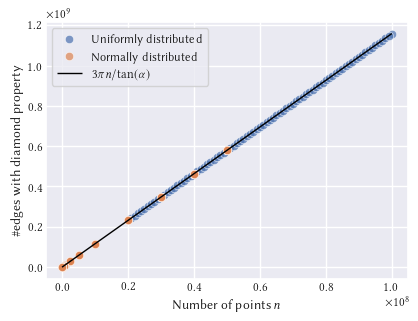

In [ ]:
sns.scatterplot(data=edges_passing_df_uniform, x="num_points", y="edges_passing_diamond_filter", 
                label="Uniformly distributed", alpha=0.7)
sns.scatterplot(data=edges_passing_df_normal, x="num_points", y="edges_passing_diamond_filter", 
                label="Normally distributed", alpha=0.7)

def theoretical_expectation(num_points):
    return 11.584608361293289630842969691108322345711246803350930891182556968 * num_points

nmax = 100 * 10**6
l1 = [(0, 0), (nmax, theoretical_expectation(nmax))]
lc = LineCollection([l1], color=["black"], lw=1, label="$3\\pi n/\\tan(\\alpha)$")
plt.gca().add_collection(lc)
plt.legend(loc="upper left")
plt.xlabel("Number of points $n$")
plt.ylabel("\\#edges with diamond property")
plt.tight_layout()
w = 4
h = w / 1.33333333333333333333333333333
plt.gcf().set_size_inches(w, h)
plt.savefig("edges_passing_diamond_filter.pdf", bbox_inches='tight')

In [ ]:
lmt_edges_random_df = random[["instance_name", "edges_passing_diamond_filter", "advanced_lmt_fixed_edges", "advanced_lmt_candidate_edges", "lmt_fixed_edges", "lmt_candidate_edges", "num_points"]].groupby("instance_name").agg("mean")
lmt_edges_random_df_normal = lmt_edges_random_df[lmt_edges_random_df.index.str.startswith("normal-")]
lmt_edges_random_df_uniform = lmt_edges_random_df[lmt_edges_random_df.index.str.startswith("uniform-")]
lmt_edges_random_df

,edges_passing_diamond_filter,advanced_lmt_fixed_edges,advanced_lmt_candidate_edges,lmt_fixed_edges,lmt_candidate_edges,num_points
instance_name,,,,,,
normal-1000-1,1.117400e+04,2504.0,1121.0,2495.0,1253.0,1000.0
normal-1000-10,1.117400e+04,2504.0,1121.0,2495.0,1253.0,1000.0
normal-1000-2,1.117400e+04,2504.0,1121.0,2495.0,1253.0,1000.0
normal-1000-3,1.117400e+04,2504.0,1121.0,2495.0,1253.0,1000.0
normal-1000-4,1.117400e+04,2504.0,1121.0,2495.0,1253.0,1000.0
...,...,...,...,...,...,...
uniform-95000000-0,1.100609e+09,239222078.0,110670357.0,238308495.0,124261858.0,95000000.0
uniform-96000000-0,1.112188e+09,241739482.0,111862591.0,240815312.0,125609932.0,96000000.0
uniform-97000000-0,1.123844e+09,244242970.0,113071039.0,243305393.0,126978212.0,97000000.0


In [ ]:
diamond_prediction = 11.584608361293289630842969691108322345711246803350930891182556968

def regression(df, relerr_output_colname, x_input_colname, y_input_colname):
    slope, intercept = linear_regression(df[x_input_colname], df[y_input_colname], proportional=True)
    assert intercept == 0.0
    df[relerr_output_colname] = (df[y_input_colname] - slope * df[x_input_colname]) / df[y_input_colname]
    return slope

lmt_fixed_prediction = regression(lmt_edges_random_df, "lmt_fixed_edges_relative_error", "num_points", "lmt_fixed_edges")
adv_lmt_fixed_prediction = regression(lmt_edges_random_df, "advanced_lmt_fixed_edges_relative_error", "num_points", "advanced_lmt_fixed_edges")
lmt_candidate_line = regression(lmt_edges_random_df, "lmt_candidate_edges_relative_error", "num_points", "lmt_candidate_edges")
adv_lmt_candidate_line = regression(lmt_edges_random_df, "advanced_lmt_candidate_edges_relative_error", "num_points", "advanced_lmt_candidate_edges")
lmt_edges_random_df["diamond_filter_prediction_relative_error"] = (lmt_edges_random_df["edges_passing_diamond_filter"] - diamond_prediction * lmt_edges_random_df["num_points"]) / lmt_edges_random_df["edges_passing_diamond_filter"]

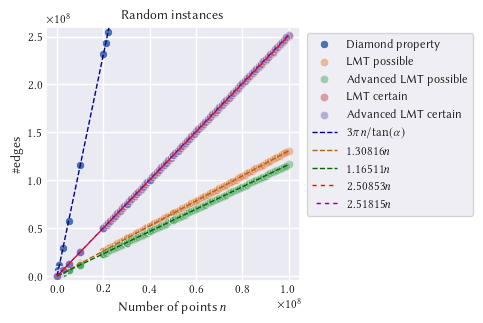

In [ ]:
sns.scatterplot(data=lmt_edges_random_df, x="num_points", y="edges_passing_diamond_filter", 
                label="Diamond property", alpha=1.0)
sns.scatterplot(data=lmt_edges_random_df, x="num_points", y="lmt_candidate_edges", 
             label="LMT possible", alpha=0.5)
sns.scatterplot(data=lmt_edges_random_df, x="num_points", y="advanced_lmt_candidate_edges", 
             label="Advanced LMT possible", alpha=0.5)
sns.scatterplot(data=lmt_edges_random_df, x="num_points", y="lmt_fixed_edges", 
             label="LMT certain", alpha=0.5)
sns.scatterplot(data=lmt_edges_random_df, x="num_points", y="advanced_lmt_fixed_edges", 
             label="Advanced LMT certain", alpha=0.5)
nmax = 100 * 10**6

# diamond line
l1 = [(0, 0), (nmax, theoretical_expectation(nmax))]
lc = LineCollection([l1], linestyle='dashed', color=["darkblue"], lw=1, label="$3\\pi n/\\tan(\\alpha)$")
plt.gca().add_collection(lc)

# lmt candidate line
l2 = [(0, 0), (nmax, lmt_candidate_line * nmax)]
lc = LineCollection([l2], linestyle='dashed', color=["#b36200"], lw=1, label=f"${lmt_candidate_line:.6g}n$")
plt.gca().add_collection(lc)

# advanced lmt candidate line
l3 = [(0, 0), (nmax, adv_lmt_candidate_line * nmax)]
lc = LineCollection([l3], linestyle='dashed', color=["darkgreen"], lw=1, label=f"${adv_lmt_candidate_line:.6g}n$")
plt.gca().add_collection(lc)

# lmt fixed line
l4 = [(0, 0), (nmax, lmt_fixed_prediction * nmax)]
lc = LineCollection([l4], linestyle=(0, (3,3)), color=["red"], lw=1, label=f"${lmt_fixed_prediction:.6g}n$")
plt.gca().add_collection(lc)

# advanced lmt fixed line
l5 = [(0, 0), (nmax, adv_lmt_fixed_prediction * nmax)]
lc = LineCollection([l5], linestyle=(3, (3,3)), color=["purple"], lw=1, label=f"${adv_lmt_fixed_prediction:.6g}n$")
plt.gca().add_collection(lc)

plt.title("Random instances")
plt.tight_layout()
w = 4
h = w / 1.33333333333333333333333333333
plt.legend(loc="upper left")
plt.xlabel("Number of points $n$")
plt.ylabel("\\#edges")
plt.ylim(-5000000, 2.6e+8)
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.gcf().set_size_inches(w, h)
plt.savefig("edges_passing_stages_random.pdf", bbox_inches='tight')

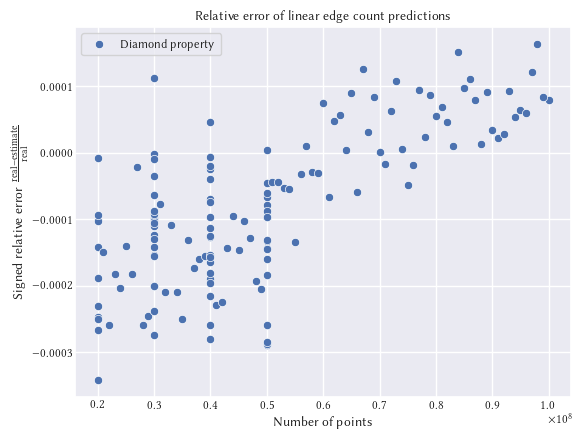

In [ ]:
above_20m = lmt_edges_random_df.query("num_points >= 20000000")
sns.scatterplot(data=above_20m, x="num_points", y="diamond_filter_prediction_relative_error", label="Diamond property")
sns.scatterplot(data=above_20m, x="num_points", y="lmt_fixed_edges_relative_error", label="LMT certain")
sns.scatterplot(data=above_20m, x="num_points", y="advanced_lmt_fixed_edges_relative_error", label="Advanced LMT certain")
sns.scatterplot(data=above_20m, x="num_points", y="lmt_candidate_edges_relative_error", label="LMT possible")
sns.scatterplot(data=above_20m, x="num_points", y="advanced_lmt_candidate_edges_relative_error", label="Advanced LMT possible")
plt.xlabel("Number of points")
plt.ylabel("Signed relative error $\\frac{\\textrm{real} - \\textrm{estimate}}{\\textrm{real}}$")
plt.title("Relative error of linear edge count predictions")
plt.legend()

In [ ]:
random.query("num_points >= 100000 & num_points <= 200000")[["num_points", "max_total_time"]]

,num_points,max_total_time
91654,100000,0.519507
91665,150000,0.749811
91671,100000,0.511987
91719,100000,0.502675
91725,150000,0.791244
...,...,...
96605,100000,0.513978
96606,100000,0.502163
96613,100000,0.505782
96614,150000,0.757619


In [ ]:
numerical.query("run_succeeded == False").sort_values("num_points")

,instance_name,instance_dir,run_type,run_index,run_succeeded,run_failure_type,advanced_lmt_candidate_edges,advanced_lmt_fixed_edges,advanced_lmt_time,diamond_time,edges_passing_diamond_filter,face_triangulation_stats,face_triangulation_time,gen_time,instance_file,lmt_candidate_edges,lmt_fixed_edges,lmt_time,max_gap,max_resource_usage,num_points,total_weight_lb,total_weight_ub,verification_mode,max_res_involuntary_context_switches,max_res_major_page_faults,max_res_max_resident_set_size,max_res_minor_page_faults,max_res_process_system_time,max_res_process_user_time,max_res_resident_set_size,max_res_swap_usage,max_res_voluntary_context_switches,max_res_total_memory,num_nonsimple_faces,total_time,max_relative_gap,min_total_time,max_total_time,total_time_dev,is_uniform_random,instance_class
83274,distant_clusters_25000,./02_raw_output/numerically_difficult,exact,5,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.494628,415.065039,0.011134,False,numerical
83419,distant_clusters_25000,./02_raw_output/numerically_difficult,exact,2,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.494628,415.065039,0.011134,False,numerical
84697,distant_clusters_25000,./02_raw_output/numerically_difficult,exact,4,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.494628,415.065039,0.011134,False,numerical
83603,distant_clusters_27500,./02_raw_output/numerically_difficult,exact,4,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.990275,29.522412,0.737606,False,numerical
83790,distant_clusters_27500,./02_raw_output/numerically_difficult,exact,1,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.990275,29.522412,0.737606,False,numerical
83553,distant_clusters_27500,./02_raw_output/numerically_difficult,exact,5,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.990275,29.522412,0.737606,False,numerical
84182,distant_clusters_35000,./02_raw_output/numerically_difficult,exact,4,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.305415,227.619734,0.125129,False,numerical
83530,distant_clusters_35000,./02_raw_output/numerically_difficult,exact,3,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.305415,227.619734,0.125129,False,numerical
83541,distant_clusters_35000,./02_raw_output/numerically_difficult,exact,2,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.305415,227.619734,0.125129,False,numerical
84282,distant_clusters_50000,./02_raw_output/numerically_difficult,exact,5,False,TIMEOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,numerical


In [ ]:
odd_wheels.query("run_succeeded == True").sort_values("face_triangulation_time")

,instance_name,instance_dir,run_type,run_index,run_succeeded,run_failure_type,advanced_lmt_candidate_edges,advanced_lmt_fixed_edges,advanced_lmt_time,diamond_time,edges_passing_diamond_filter,face_triangulation_stats,face_triangulation_time,gen_time,instance_file,lmt_candidate_edges,lmt_fixed_edges,lmt_time,max_gap,max_resource_usage,num_points,total_weight_lb,total_weight_ub,verification_mode,max_res_involuntary_context_switches,max_res_major_page_faults,max_res_max_resident_set_size,max_res_minor_page_faults,max_res_process_system_time,max_res_process_user_time,max_res_resident_set_size,max_res_swap_usage,max_res_voluntary_context_switches,max_res_total_memory,num_nonsimple_faces,total_time,max_relative_gap,min_total_time,max_total_time,total_time_dev,is_uniform_random,instance_class
97915,regpoly_7,./02_raw_output/odd_wheels,exact,4,True,None,0.0,14.0,8.000000e-08,0.000370,21.0,None,0.001902,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,0.0,14.0,0.000053,0.000000,"{'involuntary_context_switches': 0, 'major_pag...",8,13.074372,13.074372,none,0.0,0.0,1.361101e+07,947.0,0.000000,0.006443,1.361101e+07,0.0,77.0,1.361101e+07,0.0,0.002325,0.000000,0.002298,0.019489,7.480417,False,odd wheels
98291,regpoly_9,./02_raw_output/odd_wheels,inexact,3,True,None,0.0,18.0,7.000000e-08,0.000262,45.0,None,0.001906,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,0.0,18.0,0.000107,0.000000,"{'involuntary_context_switches': 0, 'major_pag...",10,15.156363,15.156363,none,0.0,0.0,1.371341e+07,921.0,0.000000,0.006538,1.371341e+07,0.0,74.0,1.371341e+07,0.0,0.002275,0.000000,0.002275,0.003097,0.361512,False,odd wheels
98586,regpoly_11,./02_raw_output/odd_wheels,inexact,3,True,None,0.0,22.0,7.000000e-08,0.000301,55.0,None,0.001915,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,0.0,22.0,0.000121,0.000000,"{'involuntary_context_switches': 0, 'major_pag...",12,17.198116,17.198116,none,0.0,0.0,1.355366e+07,953.0,0.006728,0.000000,1.355366e+07,0.0,97.0,1.355366e+07,0.0,0.002337,0.000000,0.002337,0.024041,9.286780,False,odd wheels
98170,regpoly_7,./02_raw_output/odd_wheels,inexact,4,True,None,0.0,14.0,7.000000e-08,0.000254,21.0,None,0.001925,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,0.0,14.0,0.000048,0.000000,"{'involuntary_context_switches': 1, 'major_pag...",8,13.074372,13.074372,none,1.0,0.0,1.351270e+07,911.0,0.003850,0.002288,1.351270e+07,0.0,80.0,1.351270e+07,0.0,0.002226,0.000000,0.002226,0.023598,9.598860,False,odd wheels
98256,regpoly_9,./02_raw_output/odd_wheels,exact,4,True,None,0.0,18.0,1.500000e-07,0.000268,45.0,None,0.001936,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,0.0,18.0,0.000106,0.000000,"{'involuntary_context_switches': 2, 'major_pag...",10,15.156363,15.156363,none,2.0,0.0,1.364378e+07,922.0,0.006457,0.000000,1.364378e+07,0.0,72.0,1.364378e+07,0.0,0.002310,0.000000,0.002310,0.002659,0.151358,False,odd wheels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97841,regpoly_293,./02_raw_output/odd_wheels,inexact,5,True,None,14064.0,293.0,2.563860e-01,0.039201,30668.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",5071.948752,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,14064.0,293.0,0.458132,0.050632,"{'involuntary_context_switches': 37788, 'major...",294,46.742432,46.742432,none,37788.0,0.0,3.311821e+09,3548137.0,76.149997,30986.193661,3.311821e+09,0.0,28378833.0,3.311821e+09,1.0,5072.702471,0.001083,5072.702471,5123.166957,0.009948,False,odd wheels
97359,regpoly_293,./02_raw_output/odd_wheels,inexact,4,True,None,14064.0,293.0,2.510630e-01,0.039363,30668.0,"{'nonsimple_faces': [{'cut_phase_time': 0.0, '...",5075.745312,-1.0,/misc/ibr/home/keldenic/mwt-cleanup/instance_s...,14064.0,293.0,0.453646,0.050632,"{'involuntary_context_switches': 32304, 'major...",294,46.742432,46.742432,none,32304.0,13.0,3.269575e+09,3554731.0,75.854171,30783.974690,3.269575e+09,0.0

# Plot instance regpoly_293 solve

In [ ]:
#[   17.3256]  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
#[   17.3256]
#[   17.3256]      0     0   80.81747    0 1758   95.37605   80.81747  15.3%     -    6s
#[   17.5773] H    0     0                      90.0982291   80.81747  10.3%     -    6s

_f = "([0-9.eE+-]+)"
_i = "([0-9]+)"
_s = r"\s+"
_fs = _f + _s
_fsc = "([0-9.eE+-]+|cutoff)" + _s
_is = _i + _s
_iif = "([0-9]+|\\s)" + _s
_o = r"\s*"
_t = r"\s*\[\s*([0-9.eE+-]+)\]\s*"
_in = r"(-|[0-9]+)\s+"
_gt = r"([0-9.eE+-]+)\s*[sS]\s*"
#                                  1   2   3    4     5    6    7    8   9             10   11
_bnb_log_line_re = re.compile(f"^{_t}{_is}{_is}{_fsc}{_is}{_iif}{_fs}{_fs}{_f}{_o}%{_s}{_in}{_gt}$")
#                                    1           2    3    4    5    6             7    8
_bnb_log_line_h_re = re.compile(f"^{_t}[hH]{_s}{_is}{_is}{_fs}{_fs}{_f}{_o}%{_s}{_in}{_gt}$")


def load_logfile(logfile):
    with bz2.open(logfile, "rt") as f:
        logtext = f.read()
    for l in logtext.splitlines():
        m = _bnb_log_line_re.match(l)
        if m:
            res = {"time_stamp": float(m.group(1)), 
                   "incumbent": float(m.group(7)),
                   "best_bound": float(m.group(8)),}
            yield res
            continue
        m = _bnb_log_line_h_re.match(l)
        if m:
            res = {"time_stamp": float(m.group(1)), 
                   "incumbent": float(m.group(4)),
                   "best_bound": float(m.group(5)),}
            yield res
            continue
        print("Could not match, ignoring:", l)

gurobi_steps = [[step for step in load_logfile(f"./regpoly_293_inexact_run{i}.stdout.log.bz2")] for i in range(1, 6)]

def extend_steps(steps, initial_incumbent, initial_bound):
    result = [{"time_stamp": 0.0, "incumbent": initial_incumbent, "best_bound": initial_bound}]
    current_incumbent = initial_incumbent
    current_bound = initial_bound
    for step in steps:
        eps = step["time_stamp"] - 1.0e-7
        result.append({"time_stamp": eps, "incumbent": current_incumbent, "best_bound": current_bound})
        result.append(step)
        current_incumbent = step["incumbent"]
        current_bound = step["best_bound"]
    return result

Could not match, ignoring: [    0.0068] Building quadtree took 1.298e-05 seconds
Could not match, ignoring: [    0.0459] Diamond filter (30668 edges resulting) took 0.0390644 seconds
Could not match, ignoring: [    0.4995] Normal LMT loop (293 edges fixed, 14064 remaining candidates; full triangulation must have 586 edges) took 0.453656 seconds
Could not match, ignoring: [    0.7508] Advanced LMT loop (293 edges fixed, 14064 remaining candidates) took 0.251263 seconds
Could not match, ignoring: [    0.8137] Set parameter Username
Could not match, ignoring: [    0.8146] Academic license - for non-commercial use only - expires 2025-05-23
Could not match, ignoring: [    1.0171] Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")
Could not match, ignoring: [    1.0171] 
Could not match, ignoring: [    1.0171] CPU model: AMD Ryzen 9 7900 12-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Could not match, ignoring: [    1.0171] Thread count: 12 physical c

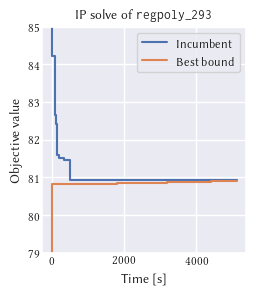

In [ ]:
dfs = [pd.DataFrame(extend_steps(gurobi_step, 200.0, 0.0)) for gurobi_step in gurobi_steps]

sns.lineplot(data=dfs[0], x="time_stamp", y="incumbent", label=f"Incumbent")
sns.lineplot(data=dfs[0], x="time_stamp", y="best_bound", label=f"Best bound")
plt.gca().set_ylim(79, 85)
plt.gca().set_xlabel("Time [s]")
plt.gca().set_ylabel("Objective value")
plt.gca().set_title("IP solve of \\texttt{regpoly_293}")
plt.gcf().set_size_inches(2.6, 3.0)
plt.tight_layout()
plt.savefig("gurobi_progression_regpoly_293.pdf", bbox_inches='tight')

In [ ]:
evolved.sort_values("num_points")

NameError: name 'evolved' is not defined